# Human Activity Recognition with IMU sensor data
We use processed [mHealth dataset](https://archive.ics.uci.edu/ml/datasets/MHEALTH+Dataset)

## Shallow Model
### Preprocessing

In [1]:
from collections import defaultdict
from glob import glob
import math
import re

import matplotlib.pyplot as plt
import numpy as np
from numpy.lib.stride_tricks import as_strided as ast
from scipy.signal import butter, freqz, filtfilt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

#### 1. Adding Size

In [2]:
def add_size(X):
    '''
    X is composed of 6 columns (x, y, z acceleration + x, y, z angular velocity)
    Add size of acceleration & size of angular velocity
    
    input  : X = (n, 3*2) numpy array
    output : X_size_added = (n, (3+1)*2) numpy array
    '''
    X_acc_size = np.linalg.norm(X[:, :3], ord=2, axis=1).reshape(-1, 1)
    X_gyro_size = np.linalg.norm(X[:, 3:], ord=2, axis=1).reshape(-1, 1)
    X_size_added = np.hstack([X, X_acc_size, X_gyro_size])
    return X_size_added

#### 2. Filtering

In [3]:
def butterworth_filter(X, cutoff, fs, order=3):  ## X is 2D-data (time, subcr),   axis=0
    '''
    Apply butterworth filter to 2d numpy array X, axis=0
    
    input  : X = (n, t) numpy array
    output : X_filtered = (n, t) numpy array
    '''
    X_filtered = []
    for i in range(X.shape[1]):
        X_filtered.append(butter_lowpass_filter(X[:, i], cutoff, fs, order))
    return np.transpose(np.array(X_filtered))

def butter_lowpass_filter(data, cutoff, fs, order=3):
    normal_cutoff = cutoff / (0.5 * fs)
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)  ## Filtering
    return y

#### 3. Sliding Window

In [4]:
# refer from http://www.johnvinyard.com/blog/?p=268
def norm_shape(shape):
    '''
    Normalize numpy array shapes so they're always expressed as a tuple,
    even for one-dimensional shapes.

    Parameters
        shape - an int, or a tuple of ints

    Returns
        a shape tuple
    '''
    try:
        i = int(shape)
        return (i,)
    except TypeError:
        # shape was not a number
        pass

    try:
        t = tuple(shape)
        return t
    except TypeError:
        # shape was not iterable
        raise TypeError('shape must be an int, or a tuple of ints')


def _sliding_window(a, ws, ss=None, flatten=True):
    '''
    Return a sliding window over a in any number of dimensions

    Parameters:
        a  - an n-dimensional numpy array
        ws - an int (a is 1D) or tuple (a is 2D or greater) representing the size
             of each dimension of the window
        ss - an int (a is 1D) or tuple (a is 2D or greater) representing the
             amount to slide the window in each dimension. If not specified, it
             defaults to ws.
        flatten - if True, all slices are flattened, otherwise, there is an
                  extra dimension for each dimension of the input.

    Returns
        an array containing each n-dimensional window from a
    '''

    if None is ss:
        # ss was not provided. the windows will not overlap in any direction.
        ss = ws

    # convert ws, ss, and a.shape to numpy arrays so that we can do math in every
    # dimension at once.
    ws = np.array(norm_shape(ws))
    ss = np.array(norm_shape(ss))
    shape = np.array(a.shape)

    # ensure that ws, ss, and a.shape all have the same number of dimensions
    ls = [len(shape), len(ws), len(ss)]
    if 1 != len(set(ls)):
        raise ValueError(
            'a.shape, ws and ss must all have the same length. They were {}'.format(ls))

    # ensure that ws is smaller than a in every dimension
    if np.any(ws > shape):
        raise ValueError(
            'ws cannot be larger than a in any dimension. a.shape was {} and ws was {}'.format(
                a.shape, ws))

    # how many slices will there be in each dimension?
    newshape = norm_shape(((shape - ws) // ss) + 1)

    # the shape of the strided array will be the number of slices in each dimension
    # plus the shape of the window (tuple addition)
    newshape += norm_shape(ws)

    # the strides tuple will be the array's strides multiplied by step size, plus
    # the array's strides (tuple addition)
    newstrides = norm_shape(np.array(a.strides) * ss) + a.strides
    strided = ast(a, shape=newshape, strides=newstrides)
    if not flatten:
        return strided

    # Collapse strided so that it has one more dimension than the window.  I.e.,
    # the new array is a flat list of slices.
    meat = len(ws) if ws.shape else 0
    firstdim = (np.product(newshape[:-meat]),) if ws.shape else ()
    dim = firstdim + (newshape[-meat:])

    # remove any dimensions with size 1
    dim = tuple(filter(lambda i: i != 1, dim))
    return strided.reshape(dim)


def sliding_window(X, ws, ss):
    '''
    _sliding_window wrapper function
    
    input:
      X - 2d numpy array
      ws - window size
      ss - window stride
    output:
      slided X - 3d numpy array
    '''
    if X.shape[0] < ws:
        return np.zeros((0, ws, *X.shape[1:]))

    X_slides = _sliding_window(
            X, (ws, *X.shape[1:]), (ss, *X.shape[1:])).reshape(-1, ws, *X.shape[1:])

    return X_slides.astype(np.float32)

#### 4. Feature Extracting

In [5]:
# Time domain features
def mean(X, axis=1):
    return np.mean(X, axis=axis)

def std(X, axis=1):
    return np.std(X, axis=axis)


# Freq domain features
def entropy(X, axis=1):
    def safe_log(_X):
        return np.log(_X.clip(1e-10))
    assert (X >= 0).all()
    p_shape = list(X.shape)
    p_shape[axis] = 1
    p = X / np.sum(X, axis=axis).reshape(p_shape)
    return np.nan_to_num(-np.sum(p * safe_log(p), axis=axis))

def energy(X, axis=1):
    return np.mean(np.square(X), axis=axis)

def coefficient_sum(X, axis=1):
    assert (X >= 0).all()
    p_shape = list(X.shape)
    p_shape[axis] = 1
    arange_shape = np.full(X.ndim, 1)
    arange_shape[axis] = X.shape[axis]
    p = X / np.sum(X, axis=axis).reshape(p_shape)
    p = np.nan_to_num(p)
    X = np.arange(X.shape[axis]).reshape(arange_shape)
    E = np.sum(X*p, axis=axis)
    return E

In [6]:
def extract_feature(X_slides, axis=1):
    X_features = []
    for tdf in [mean, std]:
        X_features.append(tdf(X_slides))
        
    X_fft_slides = np.abs(np.fft.rfft(X_slides, axis=axis))
    for fdf in [entropy, energy, coefficient_sum]:
        X_features.append(fdf(X_fft_slides))
    return np.hstack(X_features)

#### => Combining

In [7]:
SAMPLE_RATE = 50
WINDOW_SIZE = 3 * SAMPLE_RATE
WINDOW_STRIDE = int(0.06 * SAMPLE_RATE)

CUTOFF_FREQ = 10

def preprocess(X, cutoff=CUTOFF_FREQ, sample_rate=SAMPLE_RATE, ws=WINDOW_SIZE, ss=WINDOW_STRIDE):
    X_size_added = add_size(X)
    X_filtered = butterworth_filter(X_size_added, cutoff, sample_rate)
    X_slides = sliding_window(X_filtered, ws, ss)
    X_features = extract_feature(X_slides)
    return X_features

### HAR with *mHealth* data
#### Process filepath

In [8]:
DATA_BASE_DIR = 'Data/mHealth'
filepaths = glob(DATA_BASE_DIR + '/*')

In [9]:
def parse_motion_from_filepath(filepath):
    try:
        return re.search('motion=([^,]+)', filepath).group(1)
    except:
        return ''

def parse_subject_from_filepath(filepath):
    try:
        return re.search('subject=([^,]+)', filepath).group(1)
    except:
        return ''

In [10]:
SUBJECTS = sorted(list(set([parse_subject_from_filepath(filepath) for filepath in filepaths])))
MOTIONS = sorted(list(set([parse_motion_from_filepath(filepath) for filepath in filepaths])))

motion_to_label_dict = {motion:label for label, motion in enumerate(MOTIONS)}
label_to_motion_dict = {label:motion for label, motion in enumerate(MOTIONS)}

print('SUBJECTS: {}'.format(SUBJECTS))
print('MOTIONS: {}'.format(MOTIONS))

SUBJECTS: ['1', '10', '2', '3', '4', '5', '6', '7', '8', '9']
MOTIONS: ['cycling', 'lying', 'running', 'sitting', 'standing', 'walking', 'walking_up_stairs']


#### Process *mHealth* data

In [11]:
X_subject_dict = defaultdict(lambda: [])
y_subject_dict = defaultdict(lambda: [])

for filepath in filepaths:
    motion = parse_motion_from_filepath(filepath)
    label = motion_to_label_dict[motion]
    subject = parse_subject_from_filepath(filepath)
    
    with open(filepath, 'rb') as f:
        data = np.load(f)
    
    features = preprocess(data)
    X_subject_dict[subject].append(features)
    y_subject_dict[subject].append(np.full(features.shape[0], label))
    
for subject in SUBJECTS:
    X_subject_dict[subject] = np.vstack(X_subject_dict[subject])
    y_subject_dict[subject] = np.hstack(y_subject_dict[subject])

X = [X_subject_dict[subject] for subject in SUBJECTS]
y = [y_subject_dict[subject] for subject in SUBJECTS]

#### Visualize

In [12]:
def plot_confusion_matrix(y_true, y_pred, classes,
        normalize=False,
        title=None,
        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            # ... and label them with the respective list entries
            xticklabels=classes, yticklabels=classes,
            title=title,
            ylabel='True label',
            xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
            fig.tight_layout()
    plt.show()


#### Evaluate

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1950
           1       1.00      0.50      0.67      1950
           2       1.00      1.00      1.00      1950
           3       0.67      1.00      0.80      1950
           4       1.00      1.00      1.00      1950
           5       1.00      0.48      0.65      1950
           6       0.66      1.00      0.79      1950

    accuracy                           0.85     13650
   macro avg       0.90      0.85      0.84     13650
weighted avg       0.90      0.85      0.84     13650



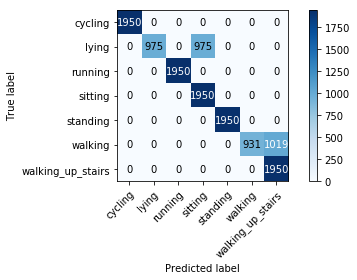

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1950
           1       0.50      0.50      0.50      1950
           2       1.00      1.00      1.00      1950
           3       0.00      0.00      0.00      1950
           4       0.67      1.00      0.80      1950
           5       1.00      0.97      0.99      1950
           6       0.97      1.00      0.98      1950

    accuracy                           0.78     13650
   macro avg       0.73      0.78      0.75     13650
weighted avg       0.73      0.78      0.75     13650



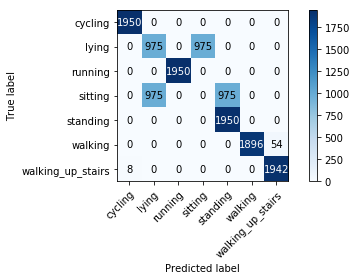

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1950
           1       1.00      0.50      0.67      1950
           2       1.00      1.00      1.00      1950
           3       0.64      1.00      0.78      1950
           4       1.00      0.93      0.96      1950
           5       0.98      0.66      0.79      1950
           6       0.74      0.98      0.85      1950

    accuracy                           0.87     13650
   macro avg       0.91      0.87      0.86     13650
weighted avg       0.91      0.87      0.86     13650



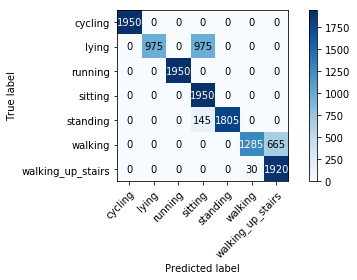

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1950
           1       0.67      1.00      0.80      1950
           2       1.00      1.00      1.00      1950
           3       1.00      0.50      0.67      1950
           4       1.00      1.00      1.00      1950
           5       1.00      0.63      0.77      1950
           6       0.70      1.00      0.82      1701

    accuracy                           0.87     13401
   macro avg       0.91      0.88      0.87     13401
weighted avg       0.91      0.87      0.87     13401



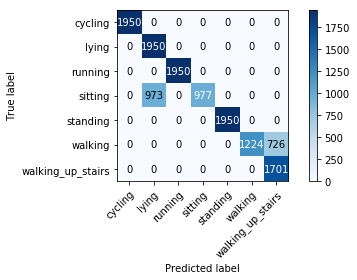

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1950
           1       1.00      1.00      1.00      1950
           2       1.00      1.00      1.00      1950
           3       1.00      1.00      1.00      1950
           4       1.00      1.00      1.00      1950
           5       0.77      0.87      0.82      1950
           6       0.85      0.73      0.78      1901

    accuracy                           0.94     13601
   macro avg       0.95      0.94      0.94     13601
weighted avg       0.95      0.94      0.94     13601



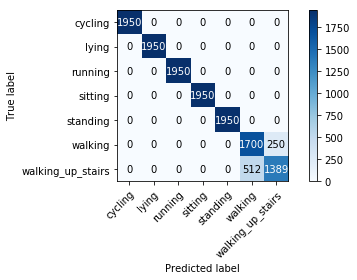

In [13]:
kf = KFold(n_splits=5)

for train_index, test_index in kf.split(X):
    X_train, X_test = np.vstack([X[i] for i in train_index]), np.vstack([X[i] for i in test_index])
    y_train, y_test = np.hstack([y[i] for i in train_index]), np.hstack([y[i] for i in test_index])
    clf = RandomForestClassifier(n_jobs=-1, n_estimators=100)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, MOTIONS)

## Deep Model

In [14]:
# For deep learning
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, CuDNNLSTM, Conv1D
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [15]:
class ConvLSTMModel:
    def __init__(self):
        self.model = None
        self.label_map = {}
        self.reverse_label_map = {}
    
    def fit(self, X, y, batch_size=100, epochs=10, **kwargs):
        self.batch_size = batch_size
        self.label_map = {label: i for i, label in enumerate(sorted(set(y)))}
        map_label = np.vectorize(lambda l: self.label_map[l])
        y = map_label(y)
        num_classes = len(set(y))
        y_one_hot_encoded = to_categorical(y, num_classes=num_classes)
        if 'validation_data' in kwargs:
            X_validation, y_validation = kwargs['validation_data']
            y_validation_one_hot_encoded = to_categorical(y_validation, num_classes=num_classes)
            kwargs['validation_data'] = (X_validation, y_validation_one_hot_encoded)
        
        input_shape = X.shape[1:]
        self.model = Sequential()
        self.model.add(Conv1D(64, 5, activation='relu', input_shape=input_shape))
        self.model.add(Conv1D(64, 5, activation='relu'))
        self.model.add(Conv1D(64, 5, activation='relu'))
        self.model.add(Conv1D(64, 5, activation='relu'))
        self.model.add(CuDNNLSTM(units=128, input_shape=input_shape, return_sequences=True))
        self.model.add(CuDNNLSTM(units=128))
        self.model.add(Dense(num_classes, activation='softmax'))
        self.model.compile(
            optimizer=Adam(),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
#         self.model.summary()

        self.history = self.model.fit(
            X, y_one_hot_encoded, epochs=epochs, batch_size=batch_size, verbose=0, **kwargs)
        return self

    def predict(self, X):
        y_pred = self.model.predict(X, batch_size=self.batch_size)
        y_pred = np.argmax(y_pred, axis=1)
        self.reverse_label_map = {i: label
                                  for label, i in self.label_map.items()}
        reverse_map_label = np.vectorize(lambda l: self.reverse_label_map[l])
        return reverse_map_label(y_pred)

In [16]:
SAMPLE_RATE = 50
WINDOW_SIZE = 3 * SAMPLE_RATE
WINDOW_STRIDE = int(0.06 * SAMPLE_RATE)

CUTOFF_FREQ = 10

def preprocess(X, cutoff=CUTOFF_FREQ, sample_rate=SAMPLE_RATE, ws=WINDOW_SIZE, ss=WINDOW_STRIDE):
    X_size_added = add_size(X)
    X_filtered = butterworth_filter(X_size_added, cutoff, sample_rate)
    X_slides = sliding_window(X_filtered, ws, ss)
    X_fft = np.abs(np.fft.rfft(X_slides, axis=1))
    return np.concatenate([X_slides, X_fft], axis=1)

In [17]:
X_subject_dict = defaultdict(lambda: [])
y_subject_dict = defaultdict(lambda: [])

for filepath in filepaths:
    motion = parse_motion_from_filepath(filepath)
    label = motion_to_label_dict[motion]
    subject = parse_subject_from_filepath(filepath)
    
    with open(filepath, 'rb') as f:
        data = np.load(f)
    
    features = preprocess(data)
    X_subject_dict[subject].append(features)
    y_subject_dict[subject].append(np.full(features.shape[0], label))
    
for subject in SUBJECTS:
    X_subject_dict[subject] = np.vstack(X_subject_dict[subject])
    y_subject_dict[subject] = np.hstack(y_subject_dict[subject])

X = [X_subject_dict[subject] for subject in SUBJECTS]
y = [y_subject_dict[subject] for subject in SUBJECTS]

/home/sameperson/.local/lib/python3.5/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1950
           1       0.50      1.00      0.67      1950
           2       0.99      0.98      0.99      1950
           3       0.00      0.00      0.00      1950
           4       1.00      1.00      1.00      1950
           5       0.67      0.96      0.79      1950
           6       0.91      0.52      0.66      1901

    accuracy                           0.78     13601
   macro avg       0.72      0.77      0.72     13601
weighted avg       0.72      0.78      0.72     13601



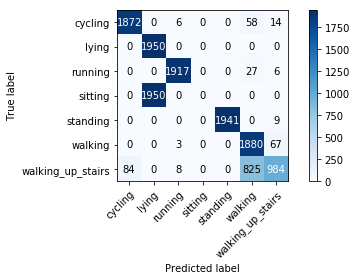

In [18]:
X_train, X_test = np.vstack([X[i] for i in range(8)]), np.vstack([X[i] for i in range(8, 10)])
y_train, y_test = np.hstack([y[i] for i in range(8)]), np.hstack([y[i] for i in range(8, 10)])

clf = ConvLSTMModel()
clf.fit(X_train, y_train, validation_data=(X_test, y_test))
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, MOTIONS)

# %% Takes long(?) time %%
#### 5-Fold Validation with Deep model

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1950
           1       1.00      0.50      0.67      1950
           2       1.00      1.00      1.00      1950
           3       0.01      0.01      0.01      1950
           4       0.49      0.99      0.65      1950
           5       1.00      0.55      0.71      1950
           6       0.69      1.00      0.81      1950

    accuracy                           0.72     13650
   macro avg       0.74      0.72      0.69     13650
weighted avg       0.74      0.72      0.69     13650



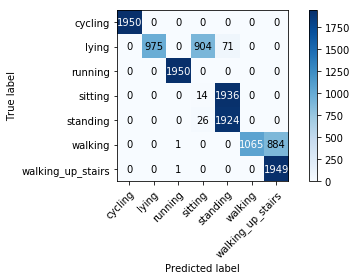

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1950
           1       0.66      0.98      0.79      1950
           2       1.00      1.00      1.00      1950
           3       0.00      0.00      0.00      1950
           4       0.55      0.64      0.60      1950
           5       0.99      0.98      0.99      1950
           6       0.97      0.99      0.98      1950

    accuracy                           0.80     13650
   macro avg       0.74      0.80      0.77     13650
weighted avg       0.74      0.80      0.77     13650



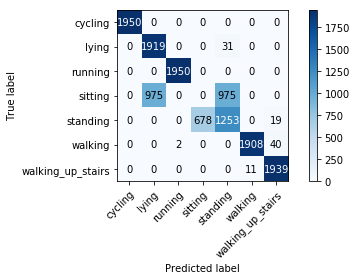

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1950
           1       0.67      0.99      0.80      1950
           2       1.00      1.00      1.00      1950
           3       0.50      0.51      0.51      1950
           4       1.00      0.50      0.67      1950
           5       0.99      0.98      0.98      1950
           6       0.98      0.99      0.98      1950

    accuracy                           0.85     13650
   macro avg       0.88      0.85      0.85     13650
weighted avg       0.88      0.85      0.85     13650



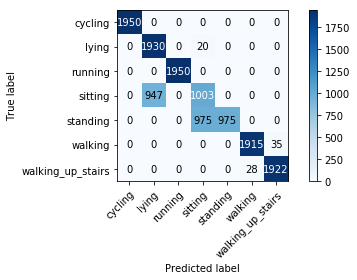

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1950
           1       0.97      0.50      0.66      1950
           2       1.00      0.87      0.93      1950
           3       0.33      0.48      0.39      1950
           4       0.46      0.50      0.48      1950
           5       0.91      0.46      0.61      1950
           6       0.59      0.91      0.72      1701

    accuracy                           0.67     13401
   macro avg       0.74      0.67      0.68     13401
weighted avg       0.74      0.67      0.68     13401



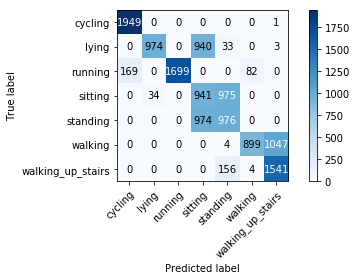

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1950
           1       1.00      0.66      0.80      1950
           2       1.00      1.00      1.00      1950
           3       0.36      0.41      0.38      1950
           4       0.50      0.61      0.55      1950
           5       0.68      1.00      0.81      1950
           6       0.98      0.53      0.69      1901

    accuracy                           0.74     13601
   macro avg       0.79      0.74      0.74     13601
weighted avg       0.79      0.74      0.74     13601



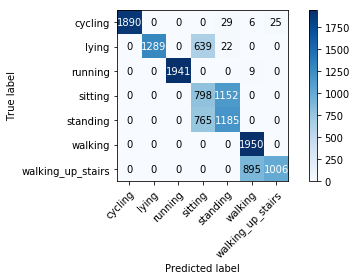

In [19]:
kf = KFold(n_splits=5)

for train_index, test_index in kf.split(X):
    X_train, X_test = np.vstack([X[i] for i in train_index]), np.vstack([X[i] for i in test_index])
    y_train, y_test = np.hstack([y[i] for i in train_index]), np.hstack([y[i] for i in test_index])
    clf = ConvLSTMModel()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, MOTIONS)